## Training

In [1]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform


import os
import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

Using TensorFlow backend.


In [17]:
from my_classes import DataGenerator, AugmentedDataGenerator

In [3]:
# Load the data
h5f = h5py.File('data_pafnucy_features', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
h5f.close()

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape, valid_x.shape, valid_y.shape)

(3231, 21, 21, 21, 19) (3231,) (404, 21, 21, 21, 19) (404,) (404, 21, 21, 21, 19) (404,)


In [5]:
# from IPython.display import SVG
# from keras.utils.vis_utils import plot_model, model_to_dot
# model_input = Input(shape=(24, 24, 24, 16))
# squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
# #plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(squeeze_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# # plot_model(get_model4((24, 24, 24, 16)))

In [6]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*4
nb_epochs = 200
l_rate = 1e-5
#decay_rate = l_rate / nb_epochs

In [18]:
data_gen = AugmentedDataGenerator(x=train_x, y=train_y, batch_size=nb_batch)
val_gen = DataGenerator(x=train_x, y=train_y, batch_size=nb_batch)

In [19]:
# data_gen = DataGenerator(x=train_x, y=train_y, batch_size=nb_batch)
# val_gen = DataGenerator(x=valid_x, y=valid_y, batch_size=nb_batch)

In [20]:
# Build the model and train
model_input = Input(shape=(21, 21, 21, 19))
pafnucy_model = Model(inputs=model_input, outputs=pafnucy_model(model_input))
model = multi_gpu_model(pafnucy_model, gpus=nb_gpus)
decay_rate = l_rate / nb_epochs
model.compile(optimizer=optimizers.adam(lr=l_rate), #, beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')
              #target_tensors=[staging_area_callback.target_tensor],
              #fetches=staging_area_callback.extra_ops)

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks_list = [EarlyStopping(monitor='val_loss', patience=10)]#, 
                  #ReduceLROnPlateau(patience=5, verbose=1)]

In [22]:
for x, y in data_gen:
    print(x.shape, y.shape)
    break

(384, 21, 21, 21, 19) (384,)


In [ ]:
history = model.fit_generator(generator=data_gen, validation_data=val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=10, 
                              workers=56, 
                              verbose=1, 
                              callbacks=callbacks_list)

Epoch 1/200
201/201 [==============================] - 535s 3s/step - loss: 1.5451 - val_loss: 1.2668
Epoch 2/200
201/201 [==============================] - 527s 3s/step - loss: 1.5426 - val_loss: 1.2382
Epoch 3/200
201/201 [==============================] - 537s 3s/step - loss: 1.5246 - val_loss: 1.2507
Epoch 4/200
201/201 [==============================] - 524s 3s/step - loss: 1.4974 - val_loss: 1.2386
Epoch 5/200
201/201 [==============================] - 525s 3s/step - loss: 1.5279 - val_loss: 1.2784
Epoch 6/200
201/201 [==============================] - 527s 3s/step - loss: 1.5226 - val_loss: 1.2782
Epoch 7/200
201/201 [==============================] - 553s 3s/step - loss: 1.5071 - val_loss: 1.2550
Epoch 8/200
201/201 [==============================] - 534s 3s/step - loss: 1.4988 - val_loss: 1.3003
Epoch 9/200
102/201 [==============>...............] - ETA: 4:24 - loss: 1.5303

In [71]:
# Save the weights
# model.save_weights('weights/weights_original.h5')

In [72]:
# model.load_weights("weights/weights-original.h5")

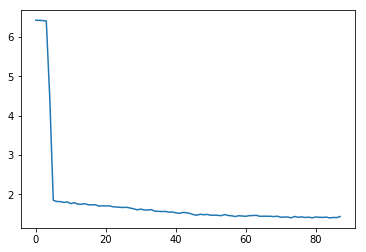

In [13]:
# First 100 epochs
plt.figure()
plt.plot(history.history['loss'])
plt.show()

In [14]:
from sklearn.metrics import r2_score

In [15]:
#train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
print("Train r2: ", train_r2)

Train r2:  0.405247568849


In [16]:
#train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
train_r2 = r2_score(y_true=test_y, y_pred=model.predict(test_x))
print("Train r2: ", train_r2)

Train r2:  0.346484938988


In [9]:
# %load models/models.py
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform, truncated_normal
from keras import regularizers

def pafnucy_model(input_tensor):
    x = Conv3D(filters=64, kernel_regularizer=regularizers.l2(0.001),
               kernel_size=(5, 5, 5),
               strides = (2, 2, 2),
               padding='same',
               activation='relu',
               kernel_initializer=truncated_normal(mean=0.0, stddev=0.001))(input_tensor)
    
    maxpool = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = Conv3D(filters=128, kernel_size=(5, 5, 5), strides=(2, 2, 2),  kernel_regularizer=regularizers.l2(0.001), kernel_initializer=truncated_normal(mean=0.0, stddev=0.001), padding='same', activation='relu', name="fire6_squeeze")(maxpool)
    maxpool = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = Conv3D(filters=256, kernel_size=(5, 5, 5), strides=(2, 2, 2),  kernel_regularizer=regularizers.l2(0.001), kernel_initializer=truncated_normal(mean=0.0, stddev=0.001), padding='same', activation='relu', name="fire7_squeeze")(maxpool)
    #maxpool = MaxPooling3D(pool_size=(2, 2, 2))(x)
    flatten = Flatten(name="flatten")(x)
    x = Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer=truncated_normal(mean=0.0, stddev=0.001))(flatten)
    x = Dropout(rate=0.5)(x)
    x = Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer=truncated_normal(mean=0.0, stddev=0.001))(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer=truncated_normal(mean=0.0, stddev=0.001))(x)
    x = Dropout(rate=0.5)(x)
    output = Dense(1, activation='linear', kernel_initializer=truncated_normal(mean=0.0, stddev=0.001))(x)
    
    #model = Model(input_tensor, output)
    
    return output

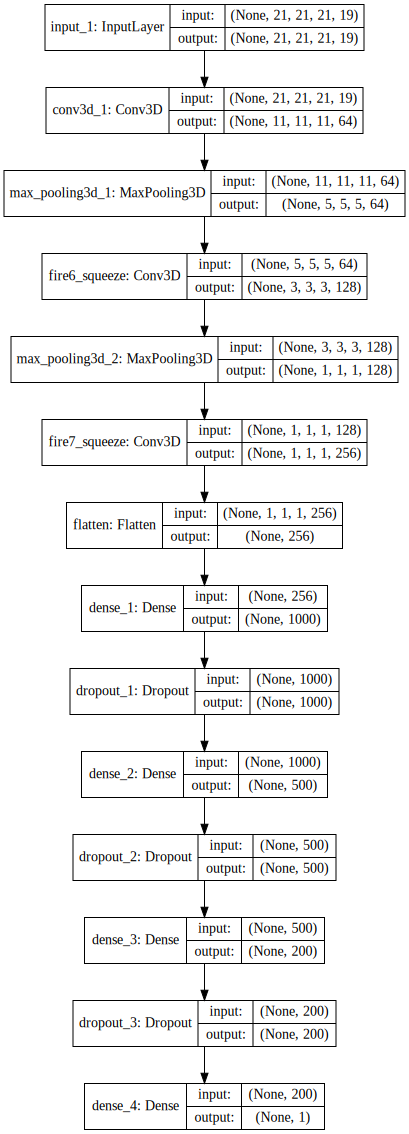

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import plot_model, model_to_dot
model_input = Input(shape=(21, 21, 21, 19))
pafnucy_model = Model(inputs=model_input, outputs=pafnucy_model(model_input))
#plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(pafnucy_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# plot_model(get_model4((24, 24, 24, 16)))